# Visualization

This Jupyter notebook visualizes results for the **1% oxygen vacancy (1pOv) BaTiO<sub>3</sub>** system.  
The analysis uses a TensorFlow-based implementation.

### Training and Evaluation

```
export ATOM_FEA_LEN=30
export BATCH_SIZE=20
export EPOCH=30
export LR=0.0005
export N_CONV=2

export train_files="graphs_Ti_indx/graphs_25fs_dump_train.npz"
export val_files="graphs_Ti_indx/graphs_25fs_dump_val.npz"
export test_files="graphs_Ti_indx/graphs_25fs_dump_test.npz"

jsrun -n1 -a1 -c42 -g1 -r1 python $PYEXE --train-flist $train_files --val-flist $val_files --test-flist $test_files \
        --mode direct --tau 1 --n-classes 3 --atom-fea-len $ATOM_FEA_LEN --n-conv $N_CONV --lr $LR --batch-size $BATCH_SIZE --n-epoch $EPOCH --job-dir tau1_M4/N3
```

In [1]:
import os
os.chdir('<PATH>/gdynet-symm')

In [2]:
import os
import numpy as np
from gdynet.model import GDyNet
from gdynet.postprocess import plot_timescales, plot_ck_tests

%matplotlib inline
import matplotlib.pyplot as plt

Define hyperparameters and file paths.

In [3]:
params = {
    'train_flist': ['<PATH>/25fs_dump/graphs_Ti_indx/graphs_25fs_dump_train.npz'],
    'val_flist': ['<PATH>/25fs_dump/graphs_Ti_indx/graphs_25fs_dump_val.npz'],
    'test_flist': ['<PATH>/25fs_dump/graphs_Ti_indx/graphs_25fs_dump_test.npz'],
   
    'job_dir': '<PATH>/25fs_dump/tau1_M4/N6',
    'mode': 'direct',
    'tau': 1,
    'n_classes': 6,
    'k_eig': 0,
    'atom_fea_len': 30,
    'n_conv': 2,
    'learning_rate': 0.0005,
    'batch_size': 20,
    'use_bn': True,
    'n_epoch': 30,
    'shuffle': True,
    'random_seed': 123,
}

gdynet = GDyNet(**params)

In [4]:
import pandas as pd

train_logs = []
for i in range(3):
    try:
        train_logs.append(pd.read_csv(os.path.join(params['job_dir'], 'train_{}.log'.format(i))))
    except FileNotFoundError:
        pass
train_logs = pd.concat(train_logs, ignore_index=True)

<AxesSubplot: >

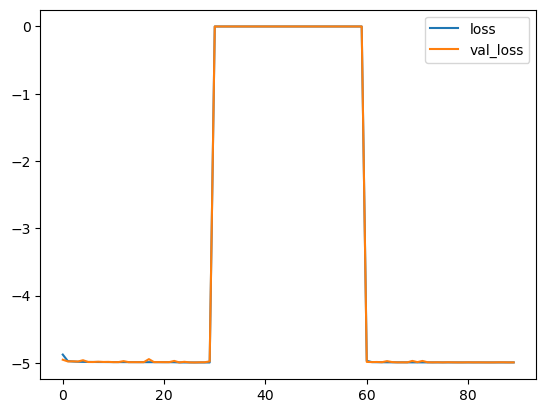

In [5]:
train_logs.plot.line(y=['loss', 'val_loss'])

<AxesSubplot: >

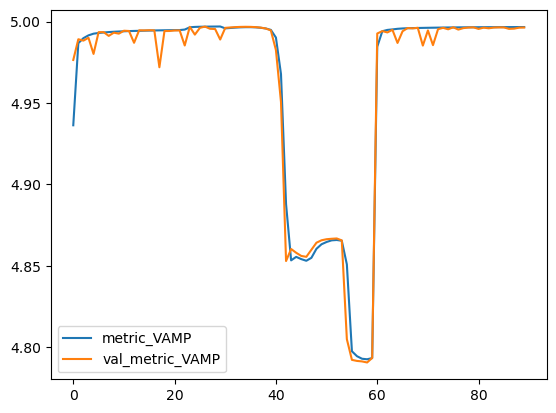

In [6]:
train_logs.plot.line(y=['metric_VAMP', 'val_metric_VAMP'])

<AxesSubplot: >

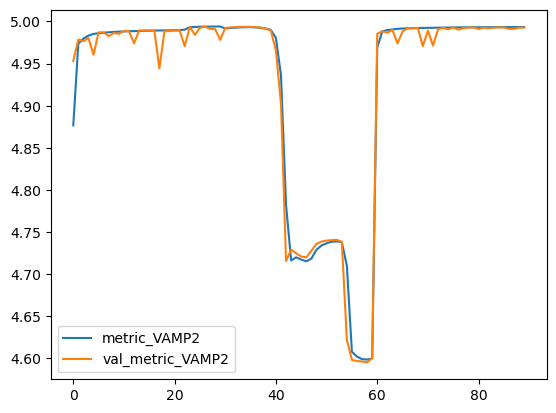

In [7]:
train_logs.plot.line(y=['metric_VAMP2', 'val_metric_VAMP2'])

Load the predicted state probabilities of the test dataset.

In [8]:
preds = np.load(os.path.join(params['job_dir'], 'test_pred.npy'))

# preds has shape (num_trajs, num_frames, num_atoms, n_classes)
preds.shape

(5, 2418, 13600, 6)

In [9]:
F = preds.shape[0]
B = preds.shape[1]
reshape_preds = preds.reshape(F*B,-1, params['n_classes'])
reshape_preds.shape

(12090, 13600, 6)

Generate a pi-chart depicting the populations of individual states.

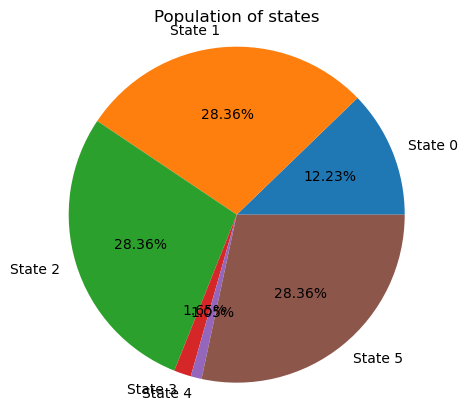

In [10]:
probs = np.sum(reshape_preds, axis=(0, 1))
probs = probs / np.sum(probs)
labels = ['State {}'.format(i) for i in range(len(probs))]
plt.figure()
plt.pie(probs, labels=labels, autopct='%1.2f%%')
plt.axis("image")
plt.title('Population of states')
plt.show()

Create a plot illustrating the evolution of relaxation timescales as a function of lag time. The relaxation timescales correspond to the characteristic times implied by the transition matrix at a given lag time. The model begins to adhere to the Markovian assumption when the relaxation timescales cease to vary. The lag time array, denoted as `lag`, is used to calculate the relaxation timescales. To estimate uncertainty, the data is divided into `n_splits` segments along the `split_axis` of the `time axis`. The `time_unit_in_ns` variable is used to convert the timesteps into units of nanoseconds.

/gpfs/alpine/mat201/scratch/asd/gdy_env_mat222/gdynet-symm/gdynet/postprocess.py:39: RuntimeWarning: invalid value encountered in log
  its_log_mean = np.mean(np.log(splited_its), axis=0)
/gpfs/alpine/mat201/scratch/asd/gdy_env_mat222/gdynet-symm/gdynet/postprocess.py:40: RuntimeWarning: invalid value encountered in log
  its_log_std = np.std(np.log(splited_its), axis=0)


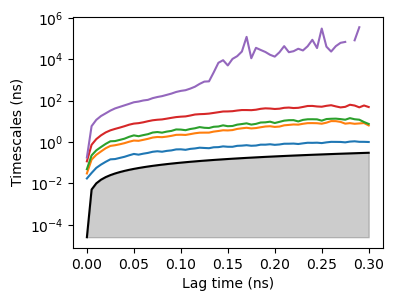

In [11]:
max_tau = 12090
time_unit_in_ns = 25e-6    #Timestep here is 1 fs, so 1e-6 ns
lag = np.arange(1, max_tau, 200)
plot_timescales(reshape_preds, lag, n_splits=1, split_axis=0, time_unit_in_ns=time_unit_in_ns)

Perform CK test. In the above figure, we know that starting at `0.15 ns`, the model start to follow the Markovian assumption (except single state). So the transition matrix with lag time `tau_msm = 6000 (0.15 ns)` should pass the CK test. We perform the CK test with `tau_msm = 6000`. The values predicted by direct multiplication the transition (blue) and estimated from the trajectory data (red) match very well. Note that we should choose the smallest `tau_msm` because it provide the most detailed dynamica information.

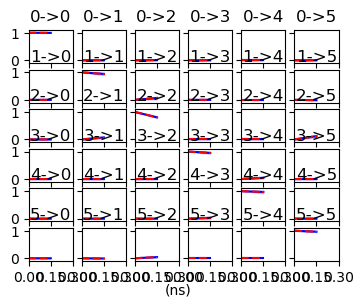

In [12]:
max_tau = 12090
time_unit_in_ns = 25e-6 
plot_ck_tests(reshape_preds, tau_msm=6000, steps=2, n_splits=5, split_axis=1, time_unit_in_ns=time_unit_in_ns)

Perform eigenvalue decomposition to the Koopman matrix (`koopman_op`)

In [13]:
tau_msm = 6000
koopman_op = gdynet.vamp.estimate_koopman_op(reshape_preds, tau_msm)
eigvals, eigvecs = np.linalg.eig(koopman_op.T)

In [14]:
def plot_eigvals(eigvals):
    plt.figure(figsize=(4, 4))
    plt.bar(range(len(eigvals)), eigvals, width=0.4)
    plt.xticks(range(len(eigvals)))
    plt.xlabel('States')
    plt.ylabel('Eigvectors')

Plot the eigenvectors corresponding to each relaxation. The largest eigenvalue should be 1 with relaxation timescale of infinity. The unrealistic timescale here is due to numerical errors. 
Eigenvectors below `0.9999` shows transitions between relevant states.

Eig 4
Value: 0.99999464
Timescale: 27961.95318537829 ns
Vector: [-0.06960955 -0.24831854 -0.21016335 -0.03054945 -0.45207122 -0.8270563 ]
Eig 5
Value: 0.9999697
Timescale: 4953.827367990045 ns
Vector: [-0.02772924 -0.17948632 -0.14605439  0.05244725  0.7839587  -0.57301134]
Eig 3
Value: 0.99497336
Timescale: 29.765951871797107 ns
Vector: [ 0.82008266 -0.14321576 -0.11363288  0.00124917 -0.01941092 -0.5419068 ]
Eig 2
Value: 0.9743047
Timescale: 5.762312726317282 ns
Vector: [-1.0017427e-03  6.8531936e-01  4.2738598e-02  2.0763888e-04
 -2.2394634e-04 -7.2698671e-01]
Eig 1
Value: 0.959097
Timescale: 3.5916930990531437 ns
Vector: [-0.00376019 -0.02201774 -0.00224908  0.7159204  -0.69774735  0.01013144]
Eig 0
Value: 0.77390426
Timescale: 0.5852355248773348 ns
Vector: [-5.3798109e-03 -3.1378481e-01  8.1167465e-01 -1.1128942e-05
  5.7154016e-06 -4.9264023e-01]


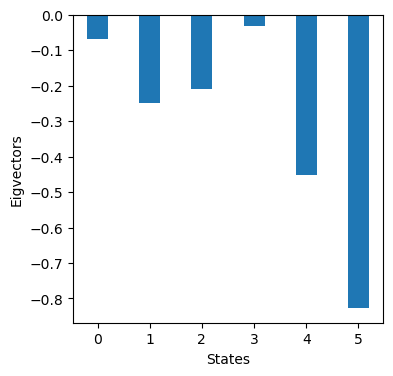

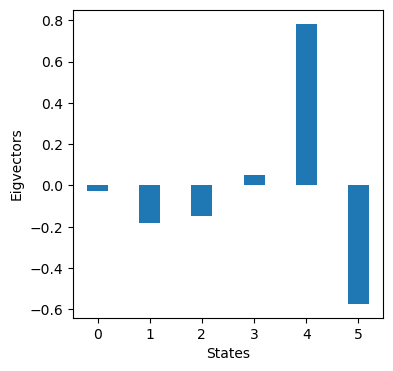

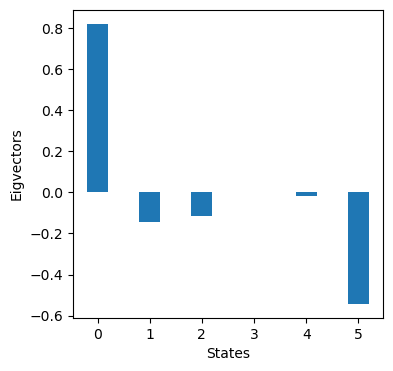

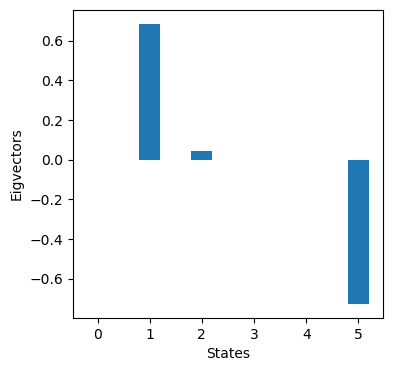

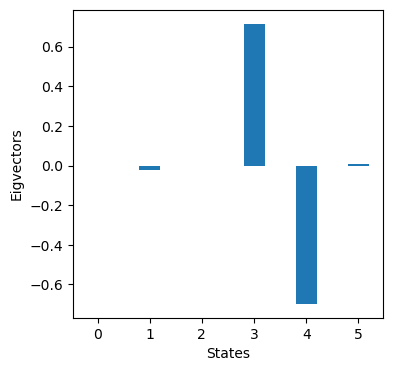

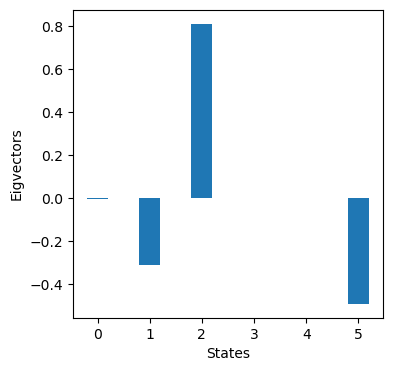

In [15]:
for i, eigval in sorted(enumerate(eigvals), key=lambda x: x[1], reverse=True):
    print('Eig {}'.format(i))
    print('Value:', eigval)
    print('Timescale: {} ns'.format(-tau_msm / np.log(np.abs(eigval)) * time_unit_in_ns))
    print('Vector:', eigvecs[:, i])
    plot_eigvals(eigvecs[:, i])

plt.show()

Visualize the probability dostrobuttion of the states in 3D.
Load the trajectory co-ordinates.

In [18]:
with np.load(params['test_flist'][0]) as data:
    traj_coords = data['traj_coords']
    target_index = data['target_index']
print(traj_coords.shape)
print(target_index.shape)

(12090, 77136, 3)
(13600,)


Following function use to plot the probabilty of each state by mapping them on `target_index` of the `traj_coords`.

In [16]:
import matplotlib
import matplotlib.cm as get_cmap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def scatter3d(x,y,z, cs, title, colorsMap='jet', angle=30):
    scaler = MinMaxScaler(feature_range=(0,1))
    cs_scaled = scaler.fit_transform(cs.reshape(-1,1)).flatten()

    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs_scaled), vmax=max(cs_scaled))
    scalarMap = get_cmap.ScalarMappable(norm=cNorm, cmap=cm)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')
    ax.axis('auto')
    ax.scatter(x, y, z, s=2, c=scalarMap.to_rgba(cs_scaled), marker='.', alpha=0.8)
    scalarMap.set_array(cs_scaled)
    ax.view_init(7, angle)
    
    # create a new Axes instance for the colorbar
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scalarMap, cax=cbar_ax)
    cbar.set_label('Probability')
    
    plt.title(title, ha='center')
    plt.show()

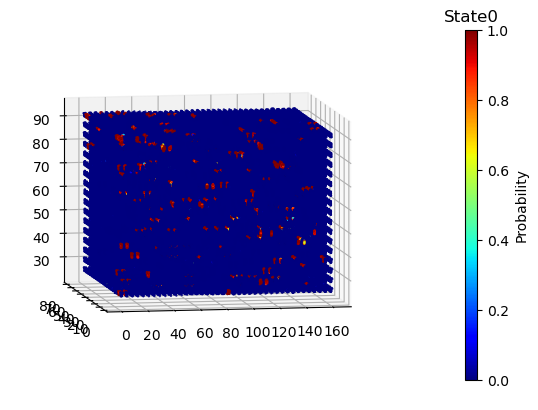

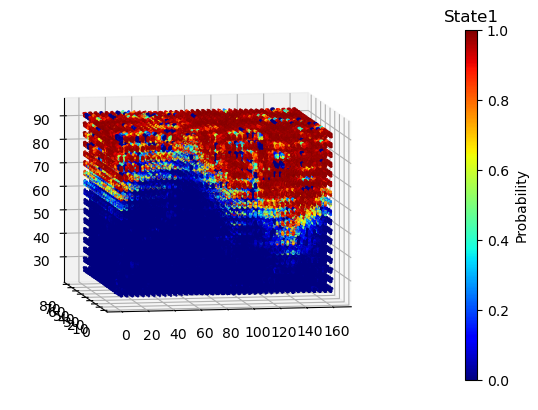

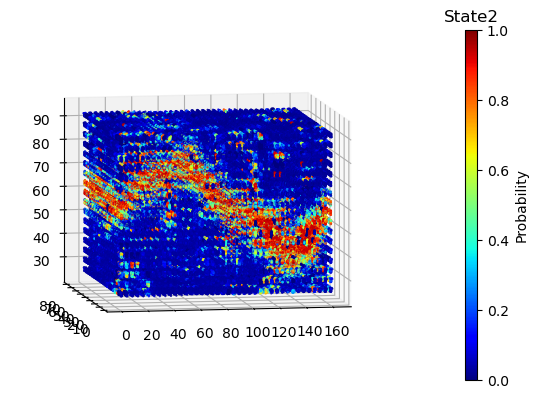

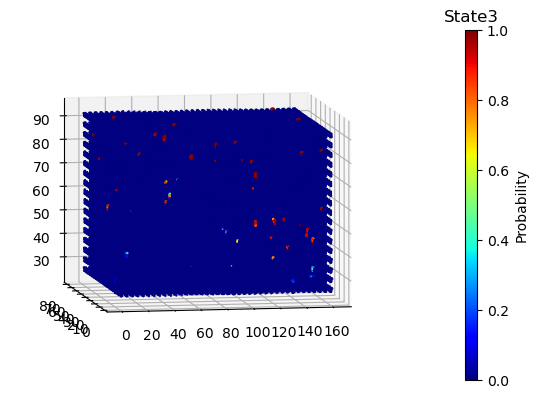

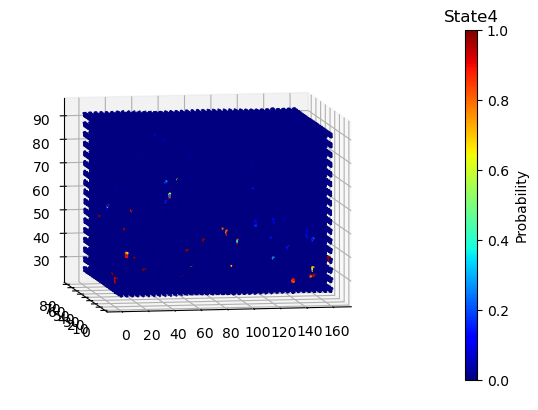

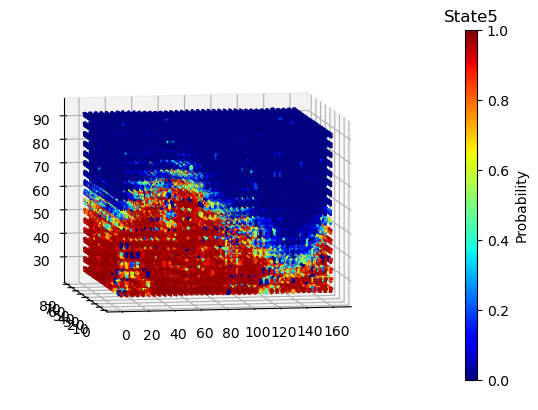

In [19]:
for i in range(params['n_classes']):
    scatter3d(traj_coords[::500, target_index, 0], traj_coords[::500, target_index, 1], traj_coords[::500, target_index, 2],
              cs=(((reshape_preds[::500]).reshape(-1,params['n_classes']))[:,i]), title='State' + str(i),angle=260)